<h1 align=center><font size=5>Speech Recognition</font></h1>

## Table of contents

- [Objective](#obj)
- [Data](#data)
- [Data Preprocessing](#data_preproc)
- [Time Domain Model](#time_model)
- [Time-Frequency Domain Model](#time_freq_model)

## Objective <a id='obj'></a>

In this notebook, we will learn how to deal with audio/voice singals. Accordingly, we will build time domain and time-frequency domain models for the purpose of speech classification.

## 1) Data <a id='data'></a>

Let us consider the Free Spoken Digit Dataset (FSDD), so called "speech MNIST" dataset. The dataset contains a set of recorded spoken digits in wav formats. You can access to this dataset in the following URL: https://github.com/Jakobovski/free-spoken-digit-dataset

&#x270d; 1.1) Download the dataset

This can be directly download to your google drive without downloading locally and then uploading

In [22]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset/

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


&#x270d; 1.2) LibROSA is a python package for music and audio analysis

 Load an audio file using librosa.load. To preserve the native sampling rate of the file, **use `sr=None`.**



In [23]:
import os
import librosa # !pip install librosa
audio_path = os.path.join(os.getcwd(), '/content/free-spoken-digit-dataset/recordings')
audio_files = os.listdir(audio_path) 
sample_audio_file = audio_files[500] # choose a random audio file
sample_audio_path = audio_path + '/' + sample_audio_file
X, sr = librosa.load(sample_audio_path, sr= None)

&#x270d; 1.3) Display the length of the audio array and sampling rate.

In [24]:
print('Length of audio: ', len(X))
print('Sampling rate ', sr)

Length of audio:  5394
Sampling rate  8000


&#x270d; 1.4) How long is the audio signal in seconds?
<br>

In [25]:
print('Audio length: {} seconds'.format(X.shape[0]/sr))

Audio length: 0.67425 seconds


&#x270d; 1.5) Play your chosen audio file and play the record

In [26]:
from IPython.display import Audio

Audio(sample_audio_path)

&#x270d; 1.6) Plot the audio signal in time domain.

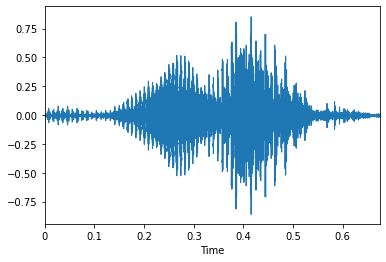

In [27]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
librosa.display.waveplot(X, sr= sr)

&#x270d; 1.7) Display the audio signal's spectrogram on a logarithmic scale using *librosa.stft*. Note that, the Short-Time Fourier Transform (STFT) represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.


Decibel:
https://en.wikipedia.org/wiki/Decibel#Acoustics



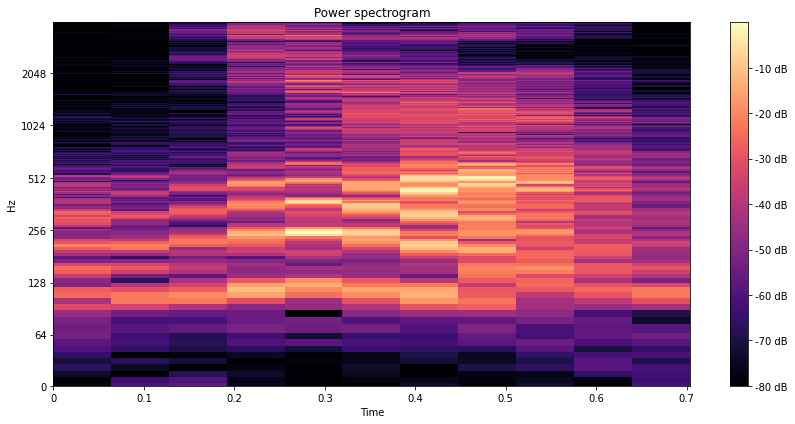

In [28]:
import numpy as np
n_fft =  1024    ## 1024
hop_length = 512 ## 512
stft = librosa.stft(X, n_fft= n_fft, hop_length= hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_dB = librosa.amplitude_to_db(stft_magnitude, ref= np.max)
plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_dB, 
                         x_axis='time', y_axis='log', 
                         sr= sr, hop_length= hop_length)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

&#x270d; 1.8) What is the hop length in seconds?

In [29]:
print('Hop length: {} seconds'.format(hop_length/sr))

Hop length: 0.064 seconds


## 2) Data Preprocessing <a id='data_preproc'></a>

&#x270d; 2.1) Find all audio files duration in seconds and sampling rate, and plot their distributions.

**Note** it can take 5-10 minutes for all audios

(array([  9.,  15.,  28.,  44.,  69., 107., 123., 139., 157., 204., 195.,
        206., 219., 204., 177., 179., 153., 141., 126.,  83.,  82.,  64.,
         67.,  49.,  30.,  23.,  15.,   9.,   7.,   9.,   8.,   8.,   2.,
          8.,   6.,   3.,   4.,   1.,   4.,   2.,   4.,   3.,   0.,   0.,
          0.,   2.,   2.,   2.,   0.,   2.,   1.,   0.,   1.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([0.14353741, 0.16492971, 0.186322  , 0.20771429, 0.22910658,
        0.25049887, 0.27189116, 0.29328345, 0.31467574, 0.33606803,
        0.35746032, 0.37885261, 0.4002449 , 0.42163719, 0.44302948,
        0.46442177, 0.48581406, 0.50720635, 0.52859864, 0.54999093,
        0.57138322, 0.59277551, 0.6141678 , 0.

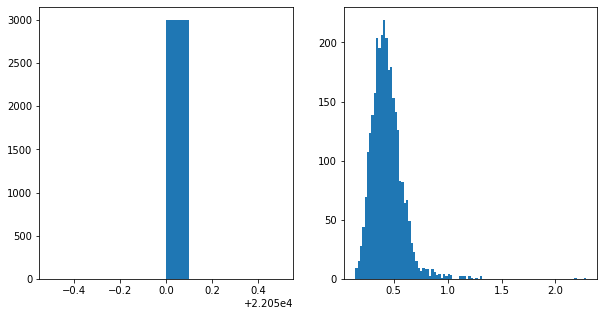

In [30]:
audio_path = os.path.join(os.getcwd(), '/content/free-spoken-digit-dataset/recordings')
audio_files = os.listdir(audio_path) 
all_audios_sr = []
all_audios_duration = []
for audio_file in audio_files:
    #print(audio_file)
    audio, sr = librosa.load(audio_path +'/'+ audio_file)
    all_audios_sr.append(sr)
    all_audios_duration.append(len(audio)/sr)
all_audios_duration = np.asarray(all_audios_duration)
all_audios_sr = np.asarray(all_audios_sr)
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.hist(all_audios_sr);
plt.subplot(1,2,2)
plt.hist(all_audios_duration, bins = 100)

&#x270d; 2.2) Clip or pad audio signals to have one second duration for all audios. Extract audio labels as well. Keep audio signals from speaker 'jackson' for test set, and the rest speakers for training.

Dataformat: Number_NAME_recordnumber.wav

In [31]:
audio_duration_sec = 1
pad = lambda a, n: a[:n] if a.shape[0] > n else np.hstack((a, np.zeros(n - a.shape[0])))
X_train, y_train = [], []
X_test, y_test = [], []
for audio_file in audio_files:
    #print(audio_file)
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    X = pad(audio, int(audio_duration_sec*sr))
    #X = pad_sequences([audio], maxlen=sr*audio_duration_sec, padding='post', truncating='post')
    #X = np.pad([audio], maxlen=sr*audio_duration_sec, padding='post', truncating='post')
    label = audio_file.split('_')[0]
    speaker = audio_file.split('_')[1]
    if (speaker=='jackson'):
        X_test.append(X)
        y_test.append(label)
    else:
        X_train.append(X)
        y_train.append(label)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [32]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2500, 8000)
X_test shape: (500, 8000)


&#x270d; 2.3) Convert the labels to a one-hot vector. 

In [33]:
from keras.utils.np_utils import to_categorical
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [34]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (2500, 10)
y_test shape: (500, 10)


## 3) Time Domain Model <a id='time_model'></a>

&#x270d; 3.1) Build a model based on time domain input signals and evaluate the classification performance of it. 

In [35]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

In [36]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim= X_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2048256   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

&#x270d;  3.2) Compile your model

In [37]:
# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss= 'categorical_crossentropy', optimizer = opt, metrics= ['accuracy'])

# Fit the model
epochs = 100
batch_size = 32
history = model.fit(X_train, y_train,epochs= epochs, batch_size= batch_size,validation_split = 0.2,shuffle = True,verbose = 1)

Epoch 1/100
63/63 [==============================] - 2s 23ms/step - loss: 2.3021 - accuracy: 0.1109 - val_loss: 2.3019 - val_accuracy: 0.1060
Epoch 2/100
63/63 [==============================] - 1s 16ms/step - loss: 2.2925 - accuracy: 0.1571 - val_loss: 2.3001 - val_accuracy: 0.1080
Epoch 3/100
63/63 [==============================] - 1s 16ms/step - loss: 2.2769 - accuracy: 0.1954 - val_loss: 2.2978 - val_accuracy: 0.1120
Epoch 4/100
63/63 [==============================] - 1s 16ms/step - loss: 2.2644 - accuracy: 0.2396 - val_loss: 2.2940 - val_accuracy: 0.1160
Epoch 5/100
63/63 [==============================] - 1s 17ms/step - loss: 2.2413 - accuracy: 0.2686 - val_loss: 2.2894 - val_accuracy: 0.1420
Epoch 6/100
63/63 [==============================] - 1s 16ms/step - loss: 2.2138 - accuracy: 0.2779 - val_loss: 2.2837 - val_accuracy: 0.1560
Epoch 7/100
63/63 [==============================] - 1s 16ms/step - loss: 2.1667 - accuracy: 0.3117 - val_loss: 2.2759 - val_accuracy: 0.1560
Epoch 

&#x270d;  3.3) Plot your accuracy

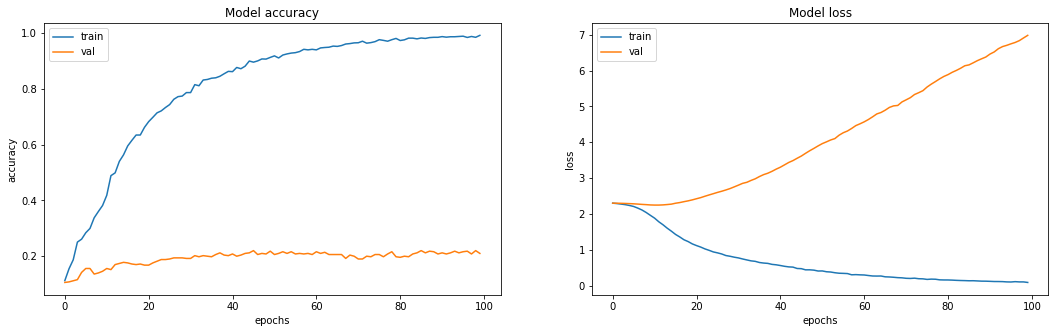

In [38]:
# My solutions
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

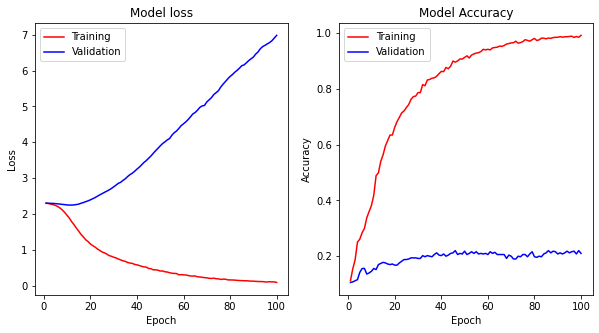

In [39]:
def plot_model(history):
    tr_loss = history.history['loss']
    tr_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(tr_loss)+1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss,'r')
    plt.plot(epochs, val_loss,'b')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_accuracy,'r')
    plt.plot(epochs, val_accuracy,'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()
plot_model(history)

&#x270d;  3.4) Evaluate your model on your test dataset

In [40]:
# Evaluate your model over test set

score, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 16.41413116455078
Test accuracy: 0.18400000035762787


## 4) Time-Frequency Domain Model <a id='time_freq_model'></a>

&#x270d; 4.1) Now, create a model based on time-frequency domain input signals and evaluate its performance.

`np.abs(librosa.stft(X))` gives you the frequency domain.

In [41]:
audio_duration_sec = 1
pad = lambda a, n: a[:n] if a.shape[0] > n else np.hstack((a, np.zeros(n - a.shape[0])))
X_train, y_train = [], []
X_test, y_test = [], []
for audio_file in audio_files:
    #print(audio_file)
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    X = pad(audio, int(audio_duration_sec*sr))
    #X = pad_sequences([audio], maxlen=sr*audio_duration_sec, padding='post', truncating='post')
    #X = np.pad([audio], maxlen=sr*audio_duration_sec, padding='post', truncating='post')
    label = audio_file.split('_')[0]
    speaker = audio_file.split('_')[1]
    if (speaker=='jackson'):
        X_test.append(np.abs(librosa.stft(X)))
        y_test.append(label)
    else:
        X_train.append(np.abs(librosa.stft(X)))
        y_train.append(label)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [42]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2500, 1025, 16)
X_test shape: (500, 1025, 16)
y_train shape: (2500,)
y_test shape: (500,)


In [43]:
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2500, 1025, 16, 1)
X_test shape: (500, 1025, 16, 1)


In [44]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (2500, 10)
y_test shape: (500, 10)


&#x270d;  4.2) Create your model

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [46]:
cnn_model = Sequential()

# Try 32 fliters first then 64
cnn_model.add(Conv2D(32,5, input_shape = (X_train[0].shape), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

#cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64,3, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
#cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
#cnn_model.add(Dense(output_dim = 32, activation = 'relu'))
#cnn_model.add(Dense(output_dim = 10, activation = 'softmax'))
cnn_model.add(Dense(10,activation='softmax'))

#flatten
#cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='softmax'))
#dense layer 10 nodes, softmax
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1021, 12, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 510, 6, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 508, 4, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 2, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32512)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                325130    
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

&#x270d;  4.3) Compile your model

In [47]:
# Compile the model
cnn_model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history1 = cnn_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
80/80 - 28s - loss: 0.6397 - accuracy: 0.2125 - val_loss: 0.6107 - val_accuracy: 0.2480
Epoch 2/10
80/80 - 27s - loss: 0.5853 - accuracy: 0.2340 - val_loss: 0.5624 - val_accuracy: 0.2320
Epoch 3/10
80/80 - 27s - loss: 0.5401 - accuracy: 0.2285 - val_loss: 0.5202 - val_accuracy: 0.2500
Epoch 4/10
80/80 - 27s - loss: 0.5026 - accuracy: 0.2270 - val_loss: 0.4858 - val_accuracy: 0.2500
Epoch 5/10
80/80 - 27s - loss: 0.4703 - accuracy: 0.2300 - val_loss: 0.4573 - val_accuracy: 0.2100
Epoch 6/10
80/80 - 26s - loss: 0.4443 - accuracy: 0.2185 - val_loss: 0.4309 - val_accuracy: 0.2600
Epoch 7/10
80/80 - 26s - loss: 0.4195 - accuracy: 0.2335 - val_loss: 0.4108 - val_accuracy: 0.2580
Epoch 8/10
80/80 - 26s - loss: 0.4019 - accuracy: 0.2125 - val_loss: 0.3931 - val_accuracy: 0.2380
Epoch 9/10
80/80 - 26s - loss: 0.3850 - accuracy: 0.2250 - val_loss: 0.3775 - val_accuracy: 0.2260
Epoch 10/10
80/80 - 26s - loss: 0.3690 - accuracy: 0.2385 - val_loss: 0.3636 - val_accuracy: 0.2580


&#x270d;  4.4) Plot your accuracy

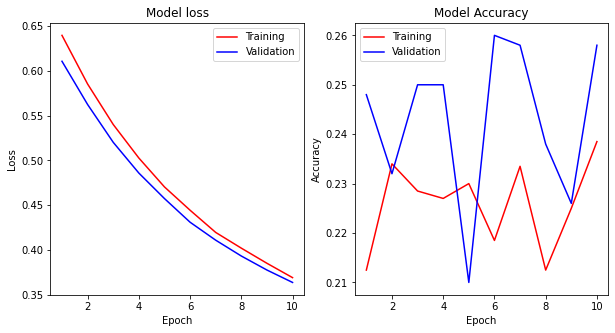

In [48]:
def plot_model(history):
    tr_loss = history1.history['loss']
    tr_accuracy = history1.history['accuracy']
    val_loss = history1.history['val_loss']
    val_accuracy = history1.history['val_accuracy']
    epochs = range(1, len(tr_loss)+1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss,'r')
    plt.plot(epochs, val_loss,'b')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_accuracy,'r')
    plt.plot(epochs, val_accuracy,'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()
plot_model(history1)

&#x270d;  4.5) Evaluate your model on your test dataset

In [49]:
score, acc = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.3731136918067932
Test accuracy: 0.20399999618530273
